# The need for sparse linear algebra - A PDE example

In modern applications we are dealing with matrices that have
hundreds of thousands to billions of unknowns. A typical feature
of these matrices is that they are highly sparse. Typically, by
sparsity we mean that a matrix mostly consists of zero elements so
that it is more economical not to store the whole matrix, but just
the nonzero entries. This makes necessary different types of storage
structures and algorithms to deal with these matrices and to efficiently
exploit the sparsity property.

Before we dive into sparse matrix storage format, we want to give a simple
example that demonstrates the necessity of sparse matrix formats and
algorithms to deal with them.

## Solving a Poisson problem on the unit square

We consider the following Poisson problem on the unit square $\Omega = [0, 1]^2$. Solve

$$
-\Delta u = 1
$$

in $\Omega$ with $x = 0$ on $\partial\Omega$. To solve this problem we consider a discretisation based on the finite difference method. Let $x_i = ih$ with $h = \frac{1}{N - 1}$ and $i=0, \dots, N - 1$. Let $y_j$ be defined similarly. We want to compute approximate solutions $u$ at the points $(x_i, y_j)$. Hence, define

$$
u_{i,j} := u(x_i, y_j).
$$

We now approximate the value $-\Delta u(x_i, y_j)$ by the following approximation.

$$
-\Delta u_{i, j}\approx \frac{4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}}{h^2}
$$

for interior points $0 < i, j < N - 1$. On boundary points we impose the condition $u_{i, j} = 0$. With this discretisation the PDE problem becomes a linear matrix problem

$$
A x = f
$$

with $f$ being a vector of all ones and the vector $x\in\mathbb{R}^{N^2}$ collects all the values $u_{i, j}$ such that $u_{i, j} = x_{jN + i}$.

We now want to implement the generation of the associated matrix. Let us calculate how many nonzero matrix elements we have. We have $(N - 2)^2$ interior points. Each row of $A$ associated with an interior point has $5$ entries. Furthermore, we have $4N - 4$ boundary points. Each boundary point requires a single diagonal entry in the matrix $A$. In total we therefore have

$$
5 (N^2 - 4N + 4) + 4N - 4 = 5N^2 - 16N + 16
$$

nonzero entries in the matrix $A$. The matrix $A$ has dimension $N^2$. Hence, there are in total $N^4$ elements. This means that the fraction of nonzero elements to overall elements is of order $O(N^{-2})$, or in other words. If we have $N = 100$ then the overall matrix dimension is $10,000$ and the number of nonzero elements is of the order of one tenthousands of the total number of matrix elements. The following is Python code that generates the matrix $A$ and the right-hand side $f$, and then solves the linear system and visualizes the solution.

We first define the function that generates the left-hand side matrix. We will discuss details of the Python commands for the sparse matrix creation later.

In [13]:
import numpy as np
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    i_ind = np.empty(nelements, dtype=np.float64)
    j_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    count = 0
    for i in range(N):
        for j in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                i_ind[count] = j_ind[count] = j * N + i
                data[count] =  1
                count += 1
            else:
                i_ind[count : count + 5] = j * N + i
                j_ind[count] = j * N + i
                j_ind[count + 1] = j * N + i + 1
                j_ind[count + 2] = j * N + i - 1
                j_ind[count + 3] = (j + 1) * N + i
                j_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                
                count += 5
                                                
    return coo_matrix((data, (i_ind, j_ind)), shape=(N**2, N**2)).tocsr()

Now we can solve the system and visualise the function u.

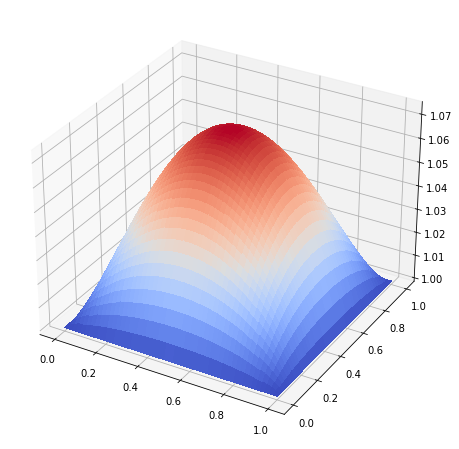

In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from scipy.sparse.linalg import spsolve

N = 200

A = discretise_poisson(N)
f = np.ones(N**2, dtype=np.float64)
sol = spsolve(A, f)

u = sol.reshape((N, N))

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')
ticks= np.linspace(0, 1, N)
X, Y = np.meshgrid(ticks, ticks)
surf = ax.plot_surface(X, Y, u, antialiased=False, cmap=cm.coolwarm)
plt.show()

Let us visualize the matrix to demonstrate the sparsity structure.

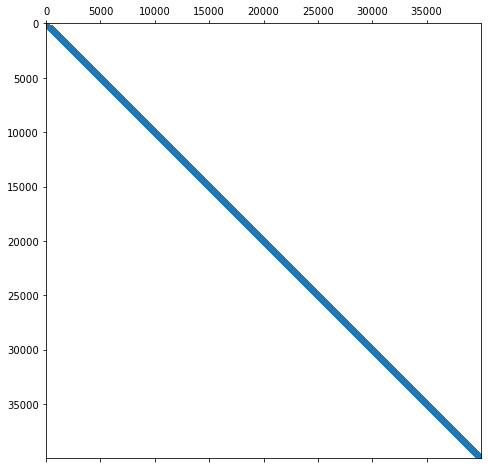

In [17]:
plt.figure(figsize=(8, 8))
plt.spy(A, markersize=1)

Let us zoom in a bit more into the matrix.

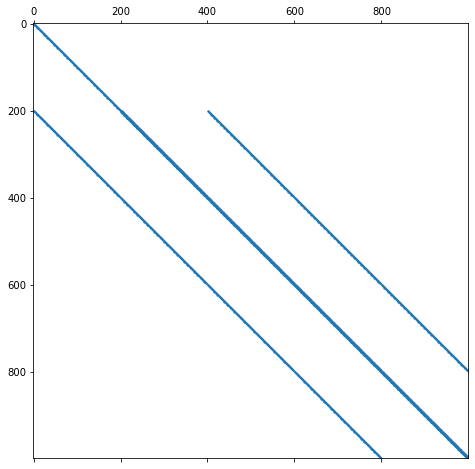

In [18]:
plt.figure(figsize=(8, 8))
plt.spy(A[:1000, :1000], markersize=1)

We can now see the banded structure of the matrix in more detail.

Let us check the size of the matrix A. A is stored in the so-called CSR format (more to this later). It uses three arrays to store the matrix. The following code prints out the overall size in bytes of those three arrays.

In [27]:
nbytes = A.data.nbytes + A.indices.nbytes + A.indptr.nbytes
print(f"The matrix A uses {round(nbytes / 1024**2, 2)} MB Ram.")

The matrix A uses 2.4 MB Ram.


What would the matrix have required had we stored a standard dense matrix? A single entry takes 8 bytes. We have $100^2\times 100^2$ entries. This results in a matrix that would have required 763 MB Ram. Moreover, performing a dense linear system solve would have required significantly more time.